In [0]:
import functools
import numpy as np
import tensorflow as tf
import pandas as pd

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow import keras


In [29]:
!pip install PyDrive
!pip install -q sklearn

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"13ZY_0SNWrQXtezuR1g29kTGOfz2_adgw"})   # replace the id with id of file you want to access
downloaded.GetContentFile('attack.csv')        # replace the file name with your file
downloaded = drive.CreateFile({'id':"1Phl_o0tXYZ0A-_cdILOm32-rMB-w1B66"})   # replace the id with id of file you want to access
downloaded.GetContentFile('benign.csv')

In [32]:
benignData = pd.read_csv('benign.csv',encoding='utf-8-sig')
attackData = pd.read_csv('attack.csv',encoding='utf-8-sig')
attackData.columns = ['protocol', 'duration', 'packetSize', 'tcp flags', 'ack', 'length']
benignData.columns = ['protocol', 'duration', 'packetSize', 'tcp flags', 'ack', 'length']
attackData.head()

,protocol,duration,packetSize,tcp flags,ack,length
0,TCP,0.010782,54,0x00000010,1,0
1,TCP,0.005140,66,0x00000002,0,0
2,TCP,0.003052,66,0x00000002,0,0
3,TCP,0.000556,66,0x00000002,0,0
4,HTTP,0.000242,74,0x00000018,1,20


In [33]:
attackData['isAttack'] = 1
benignData['isAttack']=0
attackData.pop('tcp flags') # drop unnessary column
benignData.pop('tcp flags')

0         0x00000010
1         0x00000018
2         0x00000010
3         0x00000010
4         0x00000010
             ...    
137391    0x00000010
137392    0x00000018
137393    0x00000018
137394    0x00000010
137395    0x00000010
Name: tcp flags, Length: 137396, dtype: object

In [34]:
comb=pd.concat([benignData, attackData], axis=0)
##comb.shuffle()
train, test = train_test_split(comb, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), '훈련 샘플')
print(len(val), '검증 샘플')
print(len(test), '테스트 샘플')

88422 훈련 샘플
22106 검증 샘플
27632 테스트 샘플


In [35]:
Output=comb['isAttack']
#comb=comb.drop(['Out'],axis=1)
#comb.pop('tcp.flags')

comb.head()

,protocol,duration,packetSize,ack,length,isAttack
0,TCP,0.000000,1498,1.0,1388.0,0
1,TCP,0.000144,140,1.0,30.0,0
2,TCP,0.000083,1502,1.0,1388.0,0
3,TCP,0.000538,1498,1.0,1388.0,0
4,TCP,0.000075,1502,1.0,1388.0,0


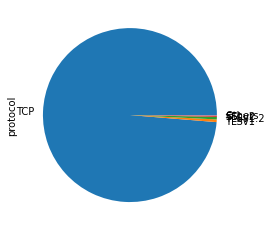

In [36]:
benignData = benignData.dropna()
#benignData['protocol'].value_counts().plot(kind='pie')
tresh = 100
a = benignData['protocol'].value_counts()
b = a[a > tresh]
b['Others'] = a[a <= tresh].sum()
b.plot.pie()

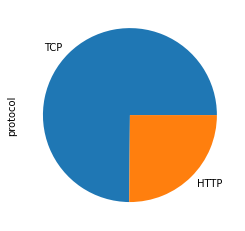

In [37]:
#attackData = attackData.dropna()

tresh = 50
a = attackData['protocol'].value_counts()
b = a[a > tresh]
b['Others'] = a[a <= tresh].sum()
b.plot.pie()

#attackData['protocol'].plot.pie(subplots=True, figsize=(10,5), autopct='%.2f', fontsize=10, labeldistance=None);
#attackData['protocol'].value_counts().plot(kind='pie')


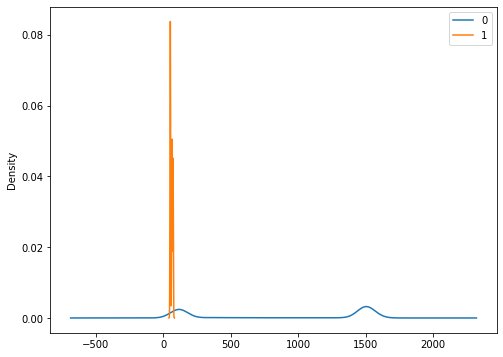

In [38]:
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
#ax = attackData['packetSize'].plot()
#fig, ax = plt.subplots(figsize=(8,6))
#bp = comb['packetSize'].plot(kind='kde', ax=ax)

fig, ax = plt.subplots(figsize=(8,6))
for label, df in comb.groupby('isAttack'):
    df['packetSize'].plot(kind="kde", ax=ax, label=label)
plt.legend()

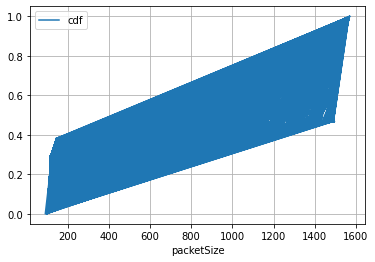

In [39]:
benignData['cdf'] = benignData['packetSize'].rank(method = 'average', pct = True)
benignData.plot(x = 'packetSize', y = ['cdf'], grid = True)

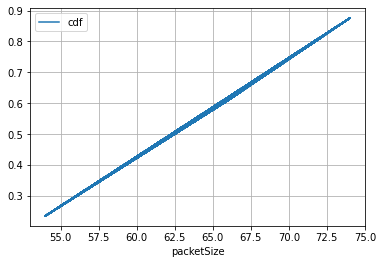

In [40]:
attackData['cdf'] = attackData['packetSize'].rank(pct = True)
attackData.plot(x = 'packetSize', y = ['cdf'], grid = True)

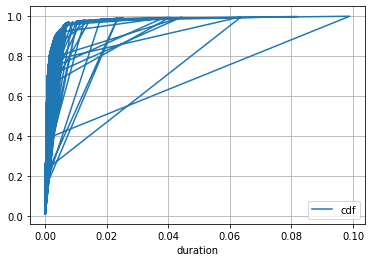

In [41]:
attackData['cdf'] = attackData['duration'].rank(pct = True)
attackData.plot(x = 'duration', y = ['cdf'], grid = True)

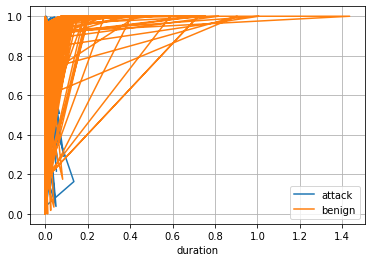

In [44]:
comb['attack'] = comb[comb['isAttack'] == 1 ]['duration'].rank(method='average', pct = True)
comb['benign'] = comb[comb['isAttack'] == 0 ]['duration'].rank(method='average',pct = True)
comb.plot(x = 'duration', y = ['attack', 'benign'], grid = True)

In [0]:
# 판다스 데이터프레임으로부터 tf.data 데이터셋을 만들기 위한 함수
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Out')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [0]:
class CategoricalTruePositives(keras.metrics.Metric):

    def __init__(self, name='categorical_true_positives', **kwargs):
      super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
      self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
      y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
      values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
      values = tf.cast(values, 'float32')
      if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, 'float32')
        values = tf.multiply(values, sample_weight)
      self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
      return self.true_positives

    def reset_states(self):
      # The state of the metric will be reset at the start of each epoch.
      self.true_positives.assign(0.)

In [0]:

batch_size = 35 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

duration = feature_column.numeric_column("duration")

feature_columns = []
feature_layer_inputs = {}
# numeric cols
for header in ['duration', 'packetSize', 'ack', 'length']:
  feature_columns.append(feature_column.numeric_column(header))
  feature_layer_inputs[header] = tf.keras.Input(shape=(1,), name=header)

# bucketized cols
duration_buckets = feature_column.bucketized_column(duration, boundaries=[0,1])
feature_columns.append(duration_buckets)

# indicator cols
protocol = feature_column.categorical_column_with_vocabulary_list(
      'protocol', ['TCP', 'UDP','TLS', 'ICMP', 'ARP', 'DNS', 'HTTP', 'SSH'])
protocol_one_hot = feature_column.indicator_column(protocol)
feature_columns.append(protocol_one_hot)
feature_layer_inputs['protocol'] = tf.keras.Input(shape=(1,), name='protocol', dtype=tf.string)

# embedding cols
protocol_embedding = feature_column.embedding_column(protocol, dimension=8)
feature_columns.append(protocol_embedding)

# crossed cols
crossed_feature = feature_column.crossed_column([duration_buckets , protocol], hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
feature_layer_outputs = feature_layer(feature_layer_inputs)

x = layers.Dense(128, activation='relu')(feature_layer_outputs)
x = layers.Dense(64, activation='relu')(x)

baggage_pred = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=[v for v in feature_layer_inputs.values()], outputs=baggage_pred)


In [45]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

Epoch 1/5
2764/2764 [==============================] - 15s 5ms/step - loss: 0.0343 - accuracy: 0.9945 - val_loss: 0.0347 - val_accuracy: 0.9944
Epoch 2/5
2764/2764 [==============================] - 15s 5ms/step - loss: 0.0343 - accuracy: 0.9945 - val_loss: 0.0348 - val_accuracy: 0.9944
Epoch 3/5
2764/2764 [==============================] - 15s 6ms/step - loss: 0.0343 - accuracy: 0.9945 - val_loss: 0.0347 - val_accuracy: 0.9944
Epoch 4/5
2764/2764 [==============================] - 15s 6ms/step - loss: 0.0343 - accuracy: 0.9945 - val_loss: 0.0349 - val_accuracy: 0.9944
Epoch 5/5
2764/2764 [==============================] - 16s 6ms/step - loss: 0.0343 - accuracy: 0.9945 - val_loss: 0.0348 - val_accuracy: 0.9944
